In [1]:
# Choose a gpu to run on
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '3'
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'True'

# automatic reloading of submodules for active development.
%load_ext autoreload
%autoreload 2

In [2]:
from hydra import initialize, compose
from hydra.utils import instantiate, call
from hydra.core.global_hydra import GlobalHydra

GlobalHydra.instance().clear()
initialize(config_path="../config")
hydra_config=compose(config_name='main', overrides=["experiment=difficult_2d", "steps_mult=4", "method=pis"])

In [3]:
from dds.configs.config import set_task, get_config
from dds.train_dds import train_dds
from dds.configs.param_settings import param_settings

base_config = get_config()

base_config.model.tfinal = hydra_config.tf
base_config.model.step_scheme = base_config.model.step_scheme_dict[
    hydra_config.step_scheme
]
base_config.model.step_scheme_key = hydra_config.step_scheme

num_steps = hydra_config.steps_mult * hydra_config.base_steps

base_config.model.dt = hydra_config.tf / num_steps
base_config.model.num_steps = num_steps
base_config.model.steps_mult = hydra_config.steps_mult

config = set_task(base_config, task=hydra_config.task)

config.seed = hydra_config.seed

config.model.sigma = hydra_config.sigma
config.model.alpha = hydra_config.alpha
# override sigma and alpha with optimised settings:
if hydra_config.reference_process_key == "pisstl":
    try:
        config.model.sigma = param_settings[hydra_config.task]["pis"]["sigma"][
            hydra_config.steps_mult
        ]
    except:
        print("no dice")
if hydra_config.reference_process_key == "oudstl":
    try:
        config.model.alpha = param_settings[hydra_config.task]["dds"]["alpha"][
            hydra_config.steps_mult
        ]
    except:
        print("no dice")

config.model.reference_process_key = hydra_config.reference_process_key

if hydra_config.reference_process_key == "pisstl":
    hydra_config.use_vi_approx = False
config.use_vi_approx = hydra_config.use_vi_approx
config.trainer.log_every_n_epochs = hydra_config.log_every_n_epochs
config.trainer.learning_rate = hydra_config.lr
config.trainer.lr_sch_base_dec = hydra_config.exp_decay
config.trainer.random_seed = hydra_config.seed
config.save_samples = hydra_config.save_samples

2024-01-26 10:33:54.561475: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
import functools
import timeit
from typing import Any, List, Tuple, Optional
from absl import app, flags

from absl import logging
import haiku as hk
import distrax
import jax
import jax.numpy as jnp

from ml_collections import config_dict as configdict
from ml_collections import config_flags

import numpy as onp
import optax

from jaxline import utils
import tqdm

from dds.configs.config import set_task
from dds.data_paths import results_path
from dds.targets.distributions import (
    NormalDistributionWrapper,
    WhitenedDistributionWrapper,
)
from dds.utils import flatten_nested_dict
import wandb

from dds.vi import get_variational_approx

def update_detached_params(
    trainable_params,
    non_trainable_params,
    attached_network_name="simple_drift_net",
    detached_network_name="stl_detach",
):
    """Auxiliary function updating detached params for STL.

    Args:
        trainable_params:
        non_trainable_params:
        attached_network_name:
        detached_network_name:
    Returns:
      Returns non trainable params
    """

    if len(trainable_params) != len(non_trainable_params):
        return non_trainable_params

    for key in trainable_params.keys():
        if attached_network_name in key:
            key_det = key.replace(attached_network_name, detached_network_name)
        else:
            key_det = key.replace("diffusion_network", detached_network_name + "_diff")
        non_trainable_params[key_det] = trainable_params[
            key
        ]  # pytype: disable=unsupported-operands

    return non_trainable_params


key = jax.random.PRNGKey(config.seed)
if config.use_vi_approx:
    print("Learning VI approximation")
    key, key_ = jax.random.split(key)
    vi_params = get_variational_approx(
        dim=config.model.input_dim,
        lr_schedule=config.vi_approx.schedule,
        batch_size=config.vi_approx.batch_size,
        iters=config.vi_approx.iters,
        rng=key_,
        target_distribution=config.target_distribution,
    )
    target_distribution = WhitenedDistributionWrapper(
        config.target_distribution,
        vi_params["Variational"]["means"],
        vi_params["Variational"]["scales"],
    )
else:
    target_distribution = config.target_distribution

In [5]:
# train setup
data_dim = config.model.input_dim
device_no = jax.device_count()

alpha = config.model.alpha
sigma = config.model.sigma
m = config.model.m

batch_size_ = int(config.model.batch_size / device_no)
batch_size_elbo = int(config.model.elbo_batch_size / device_no)

step_scheme = config.model.step_scheme_dict[config.model.step_scheme_key]

dt = config.model.dt

if config.model.reference_process_key == "oududp":
    key_conversion = {
        "pis": "pisudp",
        "vanilla": "vanilla_udp",
        "tmpis": "tmpis_udp",
    }
    # "pisudp"
    config.model.network_key = key_conversion[config.model.network_key]

net_key = config.model.network_key
network = config.model.network_dict[net_key]

tpu = config.model.tpu

detach_dif_path, detach_dritf_path = (
    config.model.detach_path,
    config.model.detach_path,
)

target = target_distribution.evaluate_log_density

tfinal = config.model.tfinal
lnpi = target_distribution.evaluate_log_density

ref_proc_key = config.model.reference_process_key
ref_proc = config.model.reference_process_dict[ref_proc_key]

trim = (
    2 if "stl" in str(ref_proc).lower() or "udp" in str(ref_proc).lower() else 1
)

stl = config.model.stl

brown = "brown" in str(ref_proc).lower()

seed = config.trainer.random_seed if "random_seed" in config.trainer else 42

# task directory (currently not in use)
task = config.task
method = config.model.reference_process_key
task_path = results_path + f"/{task}" + f"/{ref_proc_key}" + f"/{net_key}"
task_path += f"/{method}"

# checkpoiting variables for wandb
nsteps = config.model.ts.shape[0]
keep_every_nth = int(config.trainer.epochs / 125)
file_name = (
    f"/alpha_{alpha}_sigma_{sigma}_epochs_{config.trainer.epochs}"
    + f"_task_{task}_seed_{seed}_steps_{nsteps}_stl_{stl}_{method}"
    + f"_scheme_{config.model.step_scheme_key}_ddpm_test11_chk"
)
_ = task_path + file_name

detach_stl_drift = (
    config.model.detach_stl_drift
    if "detach_stl_drift" in config.model
    else False
)

drift_network = lambda: network(config.model, data_dim, "simple_drift_net")

############## wandb logging  place holder ################
data_id = "denoising_diffusion_samplers"  # Project name

# post setup model vars
# config.model.source_obj = distrax.MultivariateNormalDiag(
#     jnp.zeros(config.model.input_dim),
#     config.model.sigma * jnp.ones(config.model.input_dim),
# )
if brown:
    config.model.source_obj = NormalDistributionWrapper(
        mean=0.0,
        scale=config.model.sigma * jnp.sqrt(config.model.tfinal),
        dim=config.model.input_dim,
        is_target=False,
    )
    config.model.source = (
        lambda x: config.model.source_obj.evaluate_log_density(x, 0)[0]
    )
else:
    config.model.source_obj = NormalDistributionWrapper(
        mean=0.0,
        scale=config.model.sigma,
        dim=config.model.input_dim,
        is_target=False,
    )
    config.model.source = (
        lambda x: config.model.source_obj.evaluate_log_density(x, 0)[0]
    )

def _forward_fn(
    batch_size: int,
    density_state: int,
    training: bool = True,
    ode=False,
    exact=False,
    dt_=dt,
) -> jnp.ndarray:
    model_def = ref_proc(
        sigma,
        data_dim,
        drift_network,
        tfinal=tfinal,
        dt=dt_,
        step_scheme=step_scheme,
        alpha=alpha,
        target=target,
        tpu=tpu,
        detach_stl_drift=detach_stl_drift,
        diff_net=None,
        detach_dritf_path=detach_dritf_path,
        detach_dif_path=detach_dif_path,
        m=m,
        log=config.model.log,
        exp_bool=config.model.exp_dds,
        exact=exact,
    )

    return model_def(batch_size, density_state, training, ode=ode)

forward_fn = hk.transform_with_state(_forward_fn)

# opt and loss setup
seq = hk.PRNGSequence(seed)
rng_key = next(seq)
# subkeys = jax.random.split(rng_key, device_no)
subkeys = utils.bcast_local_devices(rng_key)

p_init = jax.pmap(
    functools.partial(
        forward_fn.init, batch_size=batch_size_, density_state=0, training=True
    ),
    axis_name="num_devices",
)

params, model_state = p_init(subkeys)

trainable_params, non_trainable_params = hk.data_structures.partition(
    lambda module, name, value: "stl_detach" not in module, params
)

nb_params = sum(x.size for x in jax.tree_util.tree_leaves(trainable_params))
print(f"Number of parameters: {nb_params}")

clipper = optax.clip(1.0)
base_dec = config.trainer.lr_sch_base_dec
scale_by_adam = optax.scale_by_adam()
# if base_dec == 0:
#   scale_by_lr = optax.scale(-config.trainer.learning_rate)
#   opt = optax.chain(clipper, scale_by_adam, scale_by_lr)
# else:
transition_steps = 50
exp_lr = optax.exponential_decay(
    config.trainer.learning_rate, transition_steps, base_dec
)
scale_lr = optax.scale_by_schedule(exp_lr)
opt = optax.chain(clipper, scale_by_adam, scale_lr, optax.scale(-1))

# opt = optax.adam(learning_rate=config.trainer.learning_rate)
opt_state = jax.pmap(opt.init)(trainable_params)

@functools.partial(
    jax.pmap,
    axis_name="num_devices",
    static_broadcasted_argnums=(3, 5, 6, 7),
)
def forward_fn_jit(
    params,
    model_state: hk.State,
    subkeys: jnp.ndarray,
    batch_size: jnp.ndarray,
    density_state: int,
    ode=False,
    exact=False,
    dt_=dt,
):
    (samps, ts, density_state), model_state = forward_fn.apply(
        params,
        model_state,
        subkeys,
        batch_size=int(batch_size / device_no),
        density_state=density_state,
        training=False,
        ode=ode,
        exact=exact,
    )
    samps = jax.device_get(samps)
    ts = jax.device_get(ts)
    density_state = jax.device_get(density_state)

    return (samps, ts, density_state), model_state

def forward_fn_wrap(
    params,
    model_state: hk.State,
    rng_key: jnp.ndarray,
    batch_size: jnp.ndarray,
    density_state: int,
    ode=False,
    exact=False,
    dt_=dt,
):
    subkeys = jax.random.split(rng_key, device_no)
    (augmented_trajectory, ts, density_state), _ = forward_fn_jit(
        params, model_state, subkeys, batch_size, density_state, ode, exact, dt_
    )

    dv, ns, t, _ = augmented_trajectory.shape
    augmented_trajectory = augmented_trajectory.reshape(dv * ns, t, -1)
    return (augmented_trajectory, utils.get_first(ts), density_state), _

def full_objective(
    trainable_params,
    non_trainable_params,
    model_state: hk.State,
    rng_key: jnp.ndarray,
    batch_size: int,
    density_state: int,
    is_training: bool = True,
    ode: bool = False,
    stl: bool = False,
    exact: bool = False,
):
    params = hk.data_structures.merge(trainable_params, non_trainable_params)
    (augmented_trajectory, _, density_state), model_state = forward_fn.apply(
        params,
        model_state,
        rng_key,
        batch_size=batch_size,
        density_state=density_state,
        training=True,
        ode=ode,
        exact=exact,
    )

    # import pdb; pdb.set_trace()
    gpartial = functools.partial(
        config.model.terminal_cost,
        lnpi=lnpi,
        source=config.model.source,
        tfinal=tfinal,
        brown=brown,
    )

    if is_training:
        loss, density_state = config.trainer.objective(
            augmented_trajectory,
            gpartial,
            density_state,
            stl=stl,
            trim=trim,
            dim=data_dim,
        )
    elif not ode:
        loss, density_state = config.trainer.lnz_is_estimator(
            augmented_trajectory, gpartial, density_state, dim=data_dim
        )
    else:
        loss, density_state = config.trainer.lnz_pf_estimator(
            augmented_trajectory,
            config.model.source,
            config.model.target,
            density_state=density_state,
        )
    return loss, (model_state, density_state)

@functools.partial(
    jax.pmap, axis_name="num_devices", static_broadcasted_argnums=(5)
)
def update(
    trainable_params,
    non_trainable_params,
    model_state: hk.State,
    opt_state: Any,
    rng_key: jnp.ndarray,
    batch_size: jnp.ndarray,
    density_state: int,
) -> Tuple[Any, Any, Any, Any, int]:
    grads, (new_model_state, density_state) = jax.grad(
        full_objective, has_aux=True
    )(
        trainable_params,
        non_trainable_params,
        model_state,
        rng_key,
        batch_size,
        density_state,
        is_training=True,
        stl=stl,
    )
    grads = jax.lax.pmean(grads, axis_name="num_devices")

    updates, opt_state = opt.update(grads, opt_state)
    new_params = optax.apply_updates(trainable_params, updates)
    return new_params, opt_state, new_model_state, jax.device_get(density_state)

@functools.partial(
    jax.pmap,
    axis_name="num_devices",
    static_broadcasted_argnums=(4, 6, 7, 8),
)
def jited_val_loss(
    trainable_params,
    non_trainable_params,
    model_state: hk.State,
    rng_key: jnp.ndarray,
    batch_size: jnp.ndarray,
    density_state: int,
    is_training: bool = True,
    ode: bool = False,
    exact: bool = False,
) -> Tuple[Any, hk.State, int]:
    loss, (new_model_state, density_state) = full_objective(
        trainable_params,
        non_trainable_params,
        model_state,
        rng_key,
        batch_size,
        density_state,
        is_training=is_training,
        ode=ode,
        stl=False,
        exact=exact,
    )

    loss = jax.lax.pmean(loss, axis_name="num_devices")
    return loss, new_model_state, density_state

def eval_report(
    trainable_params,
    non_trainable_params,
    model_state: hk.State,
    rng_key: jnp.ndarray,
    batch_size: int,
    density_state: int,
    epoch: int,
    loss_list: List[float],
    is_training: bool = True,
    print_flag: bool = False,
    ode: bool = False,
    exact: bool = False,
    wandb_run=None,
    wandb_key: Optional[str] = None,
    progress_bar: Optional[Any] = None,
) -> None:
    # if is_training:
    #     wandb_run.log({"density_calls": density_state}, step=epoch)
    loss, model_state, density_state = jited_val_loss(
        trainable_params,
        non_trainable_params,
        model_state,
        rng_key,
        batch_size,
        density_state,
        is_training,
        ode,
        exact,
    )
    loss = jax.device_get(loss)
    loss = onp.asarray(utils.get_first(loss).item()).item()

    if progress_bar:
        progress_bar.set_description(f"loss: {loss:.3f}")

    loss_list.append(loss)
    # if wandb_run:
    #     wandb_run.log({f"{wandb_key}/loss": loss}, step=epoch)

    return loss, density_state

Number of parameters: 37764


In [6]:
loss_list = []
loss_list_is = []
loss_list_pf = []

start = 0
density_state_training = jnp.array([0], dtype=jnp.int32)
times = []
progress_bar = tqdm.tqdm(list(range(start, config.trainer.epochs)))
for epoch in progress_bar:
    rng_key = next(seq)
    subkeys = jax.random.split(rng_key, device_no)

    trainable_params, opt_state, model_state, density_state_training = update(
        trainable_params,
        non_trainable_params,
        model_state,
        opt_state,
        subkeys,
        batch_size_,
        density_state_training,
    )

    if config.trainer.timer:

        def func():
            return jax.block_until_ready(
                update(
                    trainable_params,
                    non_trainable_params,
                    model_state,
                    opt_state,
                    subkeys,
                    batch_size_,
                    density_state_training,
                )
            )

        delta_time = timeit.timeit(func, number=1)
        times.append(delta_time)

    update_detached_params(
        trainable_params, non_trainable_params, "simple_drift_net", "stl_detach"
    )

    if epoch % config.trainer.log_every_n_epochs == 0:
        _, _ = eval_report(
            trainable_params,
            non_trainable_params,
            model_state,
            subkeys,
            batch_size_elbo,
            density_state_training,
            epoch,
            loss_list,
            print_flag=True,
            wandb_run=None,
            wandb_key="elbo_results",
            progress_bar=progress_bar,
        )

        _, _ = eval_report(
            trainable_params,
            non_trainable_params,
            model_state,
            subkeys,
            batch_size_elbo,
            density_state_training,
            epoch,
            loss_list_is,
            is_training=False,
            wandb_run=None,
            wandb_key="is_results",
        )

        # _, _ = eval_report(
        #     trainable_params,
        #     non_trainable_params,
        #     model_state,
        #     subkeys,
        #     batch_size_elbo,
        #     0,
        #     epoch,
        #     loss_list_pf,
        #     is_training=False,
        #     ode=True,
        #     wandb_run=run,
        #     wandb_key="pf_results",
        # )

        lr = onp.asarray(exp_lr(epoch).item()).item()
        # run.log({"lr/lr": lr}, step=epoch)

loss_list_is_eval, loss_list_eval, loss_list_pf_eval = [], [], []
for i in range(config.eval.seeds):
    rng_key = next(seq)
    subkeys = jax.random.split(rng_key, device_no)
    _, _ = eval_report(
        trainable_params,
        non_trainable_params,
        model_state,
        subkeys,
        batch_size_elbo,
        jnp.array([0], dtype=jnp.int32),
        i,
        loss_list_eval,
        print_flag=True,
        wandb_run=None,
        wandb_key="elbo_results_eval",
    )

    _, sampling_density_calls = eval_report(
        trainable_params,
        non_trainable_params,
        model_state,
        subkeys,
        batch_size_elbo,
        jnp.array([0], dtype=jnp.int32),
        i,
        loss_list_is_eval,
        is_training=False,
        wandb_run=None,
        wandb_key="is_results_eval",
    )

    # _, _ = eval_report(
    #     trainable_params,
    #     non_trainable_params,
    #     model_state,
    #     subkeys,
    #     batch_size_elbo,
    #     0,
    #     i,
    #     loss_list_pf_eval,
    #     is_training=False,
    #     ode=True,
    #     exact=False,
    #     wandb_run=run,
    #     wandb_key="pf_results_eval",
    # )
# if config.trainer.timer:
#     print(times[1:])

loss: 2.932: 100%|██████████| 10000/10000 [00:48<00:00, 205.84it/s]


In [7]:
samps = 2500
if method == "lgcp" and tfinal >= 12:
    samps = 100

params = hk.data_structures.merge(trainable_params, non_trainable_params)

(augmented_trajectory, ts, density_state), _ = forward_fn_wrap(
    params, model_state, rng_key, samps, jnp.array([0], dtype=jnp.int32)
)

(augmented_trajectory_det, ts, density_state), _  = forward_fn_wrap(
    params, model_state, rng_key, samps, jnp.array([0], dtype=jnp.int32), True, False
)

(augmented_trajectory_ext, ts, density_state), _  = forward_fn_wrap(
    params, model_state, rng_key, samps, jnp.array([0], dtype=jnp.int32), True, True
)

# results_dict = {
#     "elbo": loss_list,
#     "is": loss_list_is,
#     "pf": loss_list_pf,
#     "elbo_eval": loss_list_eval,
#     "is_eval": loss_list_is_eval,
#     # "pf_eval": loss_list_pf_eval,
#     "aug": augmented_trajectory,
#     "aug_ode": augmented_trajectory_det,
#     "aug_ode_ext": augmented_trajectory_det_ext,
# }

log_z_mean = onp.mean(loss_list_is_eval)
log_z_var = onp.var(loss_list_is_eval)
print('final_log_Z =', log_z_mean)

final_log_Z = 0.017855768203735353


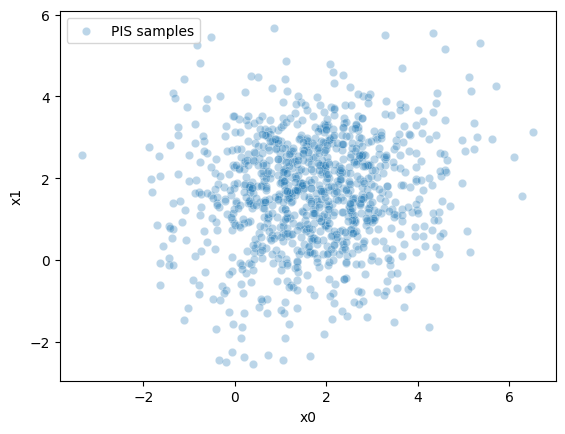

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

final_samples = augmented_trajectory[:, -1, :config.model.input_dim]

key, next_key = jax.random.split(key)
vars = [f"x{i}" for i in range(config.model.input_dim)]
final_samples_pd = pd.DataFrame(final_samples, columns=vars)
target_samples = target_distribution.sample(next_key, num_samples=samps)
target_samples_pd = pd.DataFrame(target_samples, columns=vars)

d1 = 0
d2 = 1

plt.figure()
ax=plt.gca()
sns.scatterplot(
    final_samples_pd.iloc[onp.arange(1e3)],
    x=vars[d1],
    y=vars[d2],
    ax=ax,
    label="PIS samples",
    alpha=0.3,
)
plt.savefig('/vols/ziz/not-backed-up/anphilli/diffusion_smc/benchmark_plots/mixture_samples/pis.png')
# sns.scatterplot(
#     target_samples_pd,
#     x=vars[d1],
#     y=vars[d2],
#     ax=ax,
#     label="target samples",
#     alpha=0.3,
# )
plt.show()